In [1]:
%load_ext autoreload
%autoreload 2


# Auto Encoder for Dimensionality Reduction

In [2]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import CancerDataAutoEncoder

In [3]:
# np.random.seed(42)

# # Parameters
# num_samples = 2621
# num_genes = 1800

# # Base clinical data
# clinical_data = {
#     "PatientID": [f"PID_{i}" for i in range(1, num_samples + 1)],
#     "CopyNumberVariant": np.random.randint(0, 10, size=num_samples),
#     "SmokingStatus": np.random.choice([1, 0], size=num_samples),
#     "OverallSurvivalMonths": np.random.uniform(6, 60, size=num_samples).round(2),
# }

# # Simulated gene mutation matrix: binary (0=wildtype, 1=mutated)
# mutation_matrix = np.random.choice([0, 1], size=(num_samples, num_genes), p=[0.97, 0.03])

# # Gene column names
# gene_cols = [f"Gene_{i+1}" for i in range(num_genes)]
# mutation_df = pd.DataFrame(mutation_matrix, columns=gene_cols, index=clinical_data["PatientID"])

# # Combine all data
# cancer_df = pd.concat([pd.DataFrame(clinical_data).set_index("PatientID"), mutation_df], axis=1)

# # Preview
# print(cancer_df.iloc[:, :10].head())  # Just print first 10 columns to avoid overload


In [4]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cancer_df

,SMOKING_PACK_YEARS,SMOKING_HISTORY_Current Reformed Smoker For < Or = 15 Years,SMOKING_HISTORY_Current Reformed Smoker For > 15 Years,"SMOKING_HISTORY_Current Reformed Smoker, Duration Not Specified",SMOKING_HISTORY_Current Smoker,SMOKING_HISTORY_Lifelong Non-Smoker,ONCOTREE_CODE_LUAD,ONCOTREE_CODE_LUSC,ABCA13,ABCA9,...,CNA_COL4A5,CNA_DCAF12L2,CNA_DCAF12L1,CNA_GPR112,CNA_MAGEC1,CNA_SLITRK2,CNA_AFF2,CNA_FLNA,CNA_F8,OS_MONTHS
TCGA-33-AASD-01A-11D-A401-08,84.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,111.05
TCGA-33-AASL-01A-11D-A401-08,60.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,27.17
TCGA-NK-A7XE-01A-12D-A401-08,80.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,1,1,1,1,1,1,1,1,1,0.43
TCGA-XC-AA0X-01A-32D-A401-08,30.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0.20
TCGA-33-AASI-01A-22D-A401-08,60.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,44.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-44-6775-01A-11D-1855-08,25.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,2.70
TCGA-44-6146-01A-11D-1753-08,15.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.90
TCGA-44-6147-01A-11D-1753-08,35.489939,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,7.80
TCGA-44-2662-01A-01D-0969-08,56.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,15.80


In [5]:
cancer_ds = CancerDataset(cancer_df)
cancer_ds[0][0].shape

torch.Size([989])

In [6]:
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)


In [7]:
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols)
cancer_dm.setup()

In [8]:
len(cancer_dm.ds_train), len(cancer_dm.ds_val), len(cancer_dm.ds_test)

(558, 186, 187)

In [9]:
#first batch from cancer_dm
batch = next(iter(cancer_dm.train_dataloader()))
batch[0].shape, batch[1].shape

(torch.Size([32, 203]), torch.Size([32, 1]))

In [10]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(CancerDataAutoEncoder(input_size=input_dim, latent_size=20), input_size=(32, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
CancerDataAutoEncoder                    [32, 989]                 --
├─Sequential: 1-1                        [32, 20]                  --
│    └─Linear: 2-1                       [32, 666]                 659,340
│    └─ReLU: 2-2                         [32, 666]                 --
│    └─Dropout: 2-3                      [32, 666]                 --
│    └─Linear: 2-4                       [32, 343]                 228,781
│    └─ReLU: 2-5                         [32, 343]                 --
│    └─Dropout: 2-6                      [32, 343]                 --
│    └─Linear: 2-7                       [32, 20]                  6,880
│    └─ReLU: 2-8                         [32, 20]                  --
│    └─Dropout: 2-9                      [32, 20]                  --
├─Sequential: 1-2                        [32, 989]                 --
│    └─Linear: 2-10                      [32, 343]                 7,203

In [25]:
from utils.helper_functions import create_classifier_trainer


trainer, ae_csv_logger, ae_checkpoint = create_classifier_trainer("cancer_auto_encoder")
cancer_ae = CancerDataAutoEncoder(input_size=len(cancer_dm.ds_train[0][0]), latent_size=20, n_layers=3, dropout=0.2)
trainer.fit(
    cancer_ae,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 895 K  | train
1 | decoder     | Sequential       | 895 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
1.8 M     Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [12]:
trainer.test(cancer_ae, datamodule=cancer_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5636656880378723     │
│         test_mse          │    0.5636657476425171     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5636656880378723, 'test_mse': 0.5636657476425171}]

In [13]:
def make_plots(history, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    train_history = history.dropna(subset=["train_loss"])
    val_history = history.dropna(subset=["val_loss"])
    # Loss Plot
    plt.plot(train_history["step"], train_history["train_loss"], label="Train Loss", marker="o")
    plt.plot(
        val_history["step"],
        val_history["val_loss"],
        label="Validation Loss",
        marker="o",
        linestyle="-",
    )
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()


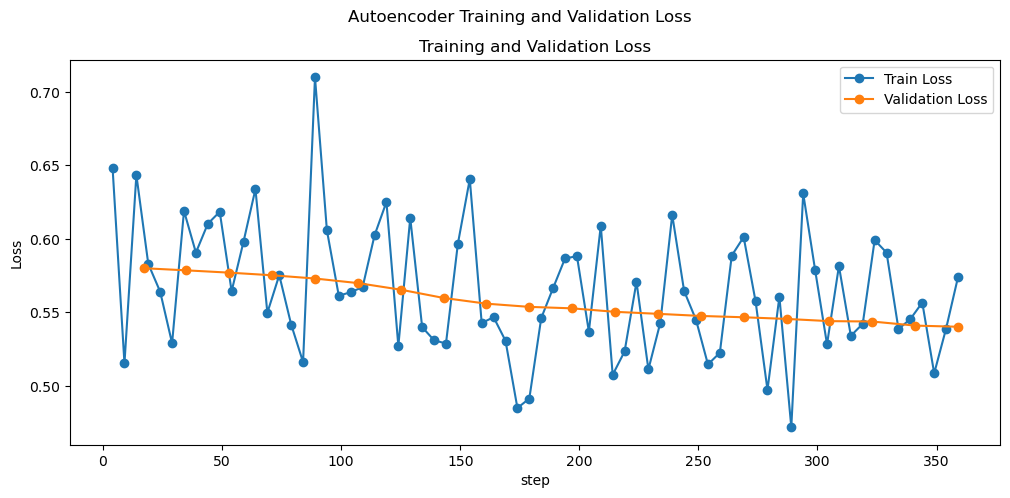

In [14]:
history = pd.read_csv(ae_csv_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")

In [15]:
import optuna

trial_to_details = {}
def objective(trial):
    latent_size = trial.suggest_int("latent_size", 3, 50)
    n_layers = trial.suggest_int("n_layers", 1, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    input_dim = len(cancer_dm.ds_train[0][0])

    model = CancerDataAutoEncoder(
        input_size=input_dim,
        latent_size=latent_size,
        n_layers=n_layers,
        dropout=dropout,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    trainer.fit(model, datamodule=cancer_dm)

    # Load validation metrics from CSV logger
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse_epoch" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse_epoch"].dropna().values[-1]
    return last_val

# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="autoencoder_study")
study.optimize(objective, n_trials=50, n_jobs=1,  show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-15 21:35:04,976] A new study created in memory with name: autoencoder_study


  0%|          | 0/50 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 186 K  | train
1 | decoder     | Sequential       | 218 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.619     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------

[I 2025-04-15 21:35:44,555] Trial 0 finished with value: 0.5563409328460693 and parameters: {'latent_size': 35, 'n_layers': 11, 'dropout': 0.3212476461953627}. Best is trial 0 with value: 0.5563409328460693.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 146 K  | train
1 | decoder     | Sequential       | 169 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:36:07,818] Trial 1 finished with value: 0.5562164783477783 and parameters: {'latent_size': 41, 'n_layers': 10, 'dropout': 0.21694216353024592}. Best is trial 1 with value: 0.5562164783477783.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 121 K  | train
1 | decoder     | Sequential       | 159 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
280 K     Trainable params
0         Non-trainable params
280 K     Total params
1.123     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:36:30,813] Trial 2 finished with value: 0.5562050342559814 and parameters: {'latent_size': 5, 'n_layers': 10, 'dropout': 0.110149150475843}. Best is trial 2 with value: 0.5562050342559814.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:37:03,866] Trial 3 finished with value: 0.5562820434570312 and parameters: {'latent_size': 41, 'n_layers': 7, 'dropout': 0.46418039694551677}. Best is trial 2 with value: 0.5562050342559814.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 55.5 K | train
1 | decoder     | Sequential       | 94.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.601     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | 

[I 2025-04-15 21:38:53,000] Trial 4 finished with value: 0.4473777711391449 and parameters: {'latent_size': 9, 'n_layers': 4, 'dropout': 0.022925940990301763}. Best is trial 4 with value: 0.4473777711391449.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 103 K  | train
1 | decoder     | Sequential       | 139 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
243 K     Trainable params
0         Non-trainable params
243 K     Total params
0.973     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:39:21,002] Trial 5 finished with value: 0.5568881034851074 and parameters: {'latent_size': 26, 'n_layers': 6, 'dropout': 0.493455433300374}. Best is trial 4 with value: 0.4473777711391449.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 174 K  | train
1 | decoder     | Sequential       | 202 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
376 K     Trainable params
0         Non-trainable params
376 K     Total params
1.508     Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:40:35,280] Trial 6 finished with value: 0.5006996393203735 and parameters: {'latent_size': 39, 'n_layers': 6, 'dropout': 0.166576791615562}. Best is trial 4 with value: 0.4473777711391449.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 174 K  | train
1 | decoder     | Sequential       | 201 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
375 K     Trainable params
0         Non-trainable params
375 K     Total params
1.504     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:40:55,306] Trial 7 finished with value: 0.5559146404266357 and parameters: {'latent_size': 6, 'n_layers': 12, 'dropout': 0.04170946257154845}. Best is trial 4 with value: 0.4473777711391449.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 111 K  | train
1 | decoder     | Sequential       | 145 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.028     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:41:18,339] Trial 8 finished with value: 0.5562500953674316 and parameters: {'latent_size': 38, 'n_layers': 10, 'dropout': 0.24028530932490622}. Best is trial 4 with value: 0.4473777711391449.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-04-15 21:41:46,076] Trial 9 finished with value: 0.5528954267501831 and parameters: {'latent_size': 50, 'n_layers': 6, 'dropout': 0.4144975537387597}. Best is trial 4 with value: 0.4473777711391449.



  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.5 K  | train
1 | decoder     | Sequential       | 3.7 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 3.3 K  | train
1 | deco

[I 2025-04-15 21:43:33,760] Trial 10 finished with value: 0.4904178977012634 and parameters: {'latent_size': 17, 'n_layers': 1, 'dropout': 0.002119405092541049}. Best is trial 4 with value: 0.4473777711391449.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 23.9 K | train
1 | decoder     | Sequential       | 24.1 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
48.0 K    Trainable params
0         Non-trainable params
48.0 K    Total params
0.192     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:45:22,750] Trial 11 finished with value: 0.4999643564224243 and parameters: {'latent_size': 16, 'n_layers': 1, 'dropout': 0.012243327346146138}. Best is trial 4 with value: 0.4473777711391449.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 40.7 K | train
1 | decoder     | Sequential       | 81.3 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.488     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:47:09,765] Trial 12 finished with value: 0.445055216550827 and parameters: {'latent_size': 15, 'n_layers': 2, 'dropout': 0.08023848171411185}. Best is trial 12 with value: 0.445055216550827.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 41.3 K | train
1 | decoder     | Sequential       | 41.5 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.331     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:48:59,390] Trial 13 finished with value: 0.4255044162273407 and parameters: {'latent_size': 13, 'n_layers': 3, 'dropout': 0.10638222318511989}. Best is trial 13 with value: 0.4255044162273407.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 44.6 K | train
1 | decoder     | Sequential       | 83.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.513     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 21:50:17,442] Trial 14 finished with value: 0.4869078993797302 and parameters: {'latent_size': 17, 'n_layers': 3, 'dropout': 0.12207585613711619}. Best is trial 13 with value: 0.4255044162273407.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:51:47,805] Trial 15 finished with value: 0.4482710063457489 and parameters: {'latent_size': 24, 'n_layers': 3, 'dropout': 0.10161225139520656}. Best is trial 13 with value: 0.4255044162273407.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 233 K  | train
1 | decoder     | Sequential       | 236 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
469 K     Trainable params
0         Non-trainable params
469 K     Total params
1.879     Total estimated model params size (MB)
97        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:52:22,800] Trial 16 finished with value: 0.5563130974769592 and parameters: {'latent_size': 12, 'n_layers': 15, 'dropout': 0.29015630918281277}. Best is trial 13 with value: 0.4255044162273407.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 60.0 K | train
1 | decoder     | Sequential       | 97.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.631     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:54:09,505] Trial 17 finished with value: 0.4790730774402618 and parameters: {'latent_size': 20, 'n_layers': 4, 'dropout': 0.16482952610779936}. Best is trial 13 with value: 0.4255044162273407.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 27.5 K | train
1 | decoder     | Sequential       | 27.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
55.2 K    Trainable params
0         Non-trainable params
55.2 K    Total params
0.221     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | 

[I 2025-04-15 21:55:50,361] Trial 18 finished with value: 0.4315076768398285 and parameters: {'latent_size': 31, 'n_layers': 2, 'dropout': 0.06590797315480373}. Best is trial 13 with value: 0.4255044162273407.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:57:34,551] Trial 19 finished with value: 0.4567323625087738 and parameters: {'latent_size': 32, 'n_layers': 4, 'dropout': 0.1669292156537509}. Best is trial 13 with value: 0.4255044162273407.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 132 K  | train
1 | decoder     | Sequential       | 165 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
297 K     Trainable params
0         Non-trainable params
297 K     Total params
1.192     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 21:58:05,642] Trial 20 finished with value: 0.5544101595878601 and parameters: {'latent_size': 31, 'n_layers': 8, 'dropout': 0.3495875424605914}. Best is trial 13 with value: 0.4255044162273407.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 26.2 K | train
1 | decoder     | Sequential       | 66.6 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
92.8 K    Trainable params
0         Non-trainable params
92.8 K    Total params
0.371     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-04-15 22:00:10,465] Trial 21 finished with value: 0.3489354848861694 and parameters: {'latent_size': 22, 'n_layers': 2, 'dropout': 0.0724548625080737}. Best is trial 21 with value: 0.3489354848861694.



  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 25.7 K | train
1 | decoder     | Sequential       | 25.9 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 5.9 K  | train
1 | deco

[I 2025-04-15 22:02:07,957] Trial 22 finished with value: 0.4328221380710602 and parameters: {'latent_size': 23, 'n_layers': 2, 'dropout': 0.07095454180290216}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:04:03,269] Trial 23 finished with value: 0.4575677216053009 and parameters: {'latent_size': 29, 'n_layers': 1, 'dropout': 0.060028782555013566}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 76.2 K | train
1 | decoder     | Sequential       | 114 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.763     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 45.7 K | train
1 | decoder    

[I 2025-04-15 22:04:49,141] Trial 24 finished with value: 0.5109854340553284 and parameters: {'latent_size': 21, 'n_layers': 5, 'dropout': 0.14077953982955999}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-04-15 22:06:39,332] Trial 25 finished with value: 0.4513494968414306 and parameters: {'latent_size': 28, 'n_layers': 3, 'dropout': 0.2078116035116812}. Best is trial 21 with value: 0.3489354848861694.



  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 23.6 K | train
1 | decoder     | Sequential       | 64.4 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
88.0 K    Trainable params
0         Non-trainable params
88.0 K    Total params
0.352     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 71.6 K | train
1 | deco

[I 2025-04-15 22:08:34,855] Trial 26 finished with value: 0.37720787525177 and parameters: {'latent_size': 12, 'n_layers': 2, 'dropout': 0.053144089234532385}. Best is trial 21 with value: 0.3489354848861694.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 21.3 K | train
1 | decoder     | Sequential       | 21.5 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
42.8 K    Trainable params
0         Non-trainable params
42.8 K    Total params
0.171     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:09:47,376] Trial 27 finished with value: 0.5103661417961121 and parameters: {'latent_size': 11, 'n_layers': 5, 'dropout': 0.189639396448818}. Best is trial 21 with value: 0.3489354848861694.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:11:38,238] Trial 28 finished with value: 0.5149022936820984 and parameters: {'latent_size': 3, 'n_layers': 2, 'dropout': 0.13077135318956318}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 233 K  | train
1 | decoder     | Sequential       | 239 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
473 K     Trainable params
0         Non-trainable params
473 K     Total params
1.893     Total estimated model params size (MB)
97        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 115 K  | train
1 | decoder    

[I 2025-04-15 22:12:08,153] Trial 29 finished with value: 0.5563725829124451 and parameters: {'latent_size': 13, 'n_layers': 15, 'dropout': 0.28537338008377305}. Best is trial 21 with value: 0.3489354848861694.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 28.5 K | train
1 | decoder     | Sequential       | 28.6 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
57.1 K    Trainable params
0         Non-trainable params
57.1 K    Total params
0.228     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:13:30,584] Trial 30 finished with value: 0.502517819404602 and parameters: {'latent_size': 8, 'n_layers': 8, 'dropout': 0.09349570788287814}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 52.7 K | train
1 | decoder     | Sequential       | 90.2 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.572     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:15:25,003] Trial 31 finished with value: 0.427946537733078 and parameters: {'latent_size': 35, 'n_layers': 2, 'dropout': 0.04163000512371834}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 43.6 K | train
1 | decoder     | Sequential       | 83.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.509     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:17:28,748] Trial 32 finished with value: 0.3574795126914978 and parameters: {'latent_size': 45, 'n_layers': 3, 'dropout': 0.03666884267245099}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:19:17,775] Trial 33 finished with value: 0.3962807059288025 and parameters: {'latent_size': 22, 'n_layers': 3, 'dropout': 0.03726648409667925}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 90.0 K | train
1 | decoder     | Sequential       | 126 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | 

[I 2025-04-15 22:21:19,800] Trial 34 finished with value: 0.4524770081043243 and parameters: {'latent_size': 46, 'n_layers': 5, 'dropout': 0.036910797127270446}. Best is trial 21 with value: 0.3489354848861694.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 9.0 K  | train
1 | decoder     | Sequential       | 9.1 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params
0.072     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:23:04,000] Trial 35 finished with value: 0.4491447806358337 and parameters: {'latent_size': 20, 'n_layers': 4, 'dropout': 0.008157938243910326}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:24:56,414] Trial 36 finished with value: 0.4206843972206116 and parameters: {'latent_size': 44, 'n_layers': 1, 'dropout': 0.049466990542058525}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 215 K  | train
1 | decoder     | Sequential       | 230 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.781     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:25:19,973] Trial 37 finished with value: 0.556174635887146 and parameters: {'latent_size': 26, 'n_layers': 13, 'dropout': 0.08402814294658997}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 114 K  | train
1 | decoder     | Sequential       | 115 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 138 K  | train
1 | decoder    

[I 2025-04-15 22:27:11,366] Trial 38 finished with value: 0.5232307314872742 and parameters: {'latent_size': 35, 'n_layers': 7, 'dropout': 0.03416532125244231}. Best is trial 21 with value: 0.3489354848861694.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:27:44,779] Trial 39 finished with value: 0.5538524389266968 and parameters: {'latent_size': 23, 'n_layers': 9, 'dropout': 0.14553220827566926}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 55.5 K | train
1 | decoder     | Sequential       | 94.8 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.601     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-15 22:28:17,679] Trial 40 finished with value: 0.5489131212234497 and parameters: {'latent_size': 9, 'n_layers': 4, 'dropout': 0.36165390640802453}. Best is trial 21 with value: 0.3489354848861694.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 8.8 K  | train
1 | decoder     | Sequential       | 8.9 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | 

[I 2025-04-15 22:30:10,631] Trial 41 finished with value: 0.4223605096340179 and parameters: {'latent_size': 43, 'n_layers': 1, 'dropout': 0.027613854484627304}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 51.6 K | train
1 | decoder     | Sequential       | 51.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.413     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:31:56,834] Trial 42 finished with value: 0.4191930294036865 and parameters: {'latent_size': 49, 'n_layers': 1, 'dropout': 0.05130578448908476}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 31.4 K | train
1 | decoder     | Sequential       | 31.6 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
63.0 K    Trainable params
0         Non-trainable params
63.0 K    Total params
0.252     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:33:49,272] Trial 43 finished with value: 0.4454116225242615 and parameters: {'latent_size': 50, 'n_layers': 3, 'dropout': 0.0007851875185849455}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 31.0 K | train
1 | decoder     | Sequential       | 70.3 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:35:40,651] Trial 44 finished with value: 0.4191915392875671 and parameters: {'latent_size': 47, 'n_layers': 2, 'dropout': 0.05651136577874255}. Best is trial 21 with value: 0.3489354848861694.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 48.6 K | train
1 | decoder     | Sequential       | 48.7 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
97.3 K    Trainable params
0         Non-trainable params
97.3 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:37:35,290] Trial 45 finished with value: 0.3302121460437774 and parameters: {'latent_size': 38, 'n_layers': 2, 'dropout': 0.08362845598146633}. Best is trial 45 with value: 0.3302121460437774.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 84.1 K | train
1 | decoder     | Sequential       | 122 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.828     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:39:27,381] Trial 46 finished with value: 0.4592666029930115 and parameters: {'latent_size': 41, 'n_layers': 3, 'dropout': 0.11315153795775375}. Best is trial 45 with value: 0.3302121460437774.


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 92.1 K | train
1 | decoder     | Sequential       | 127 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.876     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:41:31,544] Trial 47 finished with value: 0.4585248231887817 and parameters: {'latent_size': 37, 'n_layers': 5, 'dropout': 0.0868296917185099}. Best is trial 45 with value: 0.3302121460437774.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 29.4 K | train
1 | decoder     | Sequential       | 29.6 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
59.0 K    Trainable params
0         Non-trainable params
59.0 K    Total params
0.236     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-15 22:43:16,968] Trial 48 finished with value: 0.4772632420063019 and parameters: {'latent_size': 19, 'n_layers': 6, 'dropout': 0.01868005236557402}. Best is trial 45 with value: 0.3302121460437774.


`Trainer.fit` stopped: `max_epochs=100` reached.


[I 2025-04-15 22:45:09,063] Trial 49 finished with value: 0.4337142705917358 and parameters: {'latent_size': 39, 'n_layers': 2, 'dropout': 0.07675327939292965}. Best is trial 45 with value: 0.3302121460437774.
Best trial:
  Value (val_mse): 0.3302121460437774
  Params:
    latent_size: 38
    n_layers: 2
    dropout: 0.08362845598146633


In [16]:
results = study.trials_dataframe()
results.to_csv(f"results/02/hyperparmeter_tuning_results.csv", index=False)

In [17]:
results

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_latent_size,params_n_layers,state
0,0,0.556341,2025-04-15 21:35:04.985463,2025-04-15 21:35:44.554858,0 days 00:00:39.569395,0.321248,35,11,COMPLETE
1,1,0.556216,2025-04-15 21:35:44.558503,2025-04-15 21:36:07.818043,0 days 00:00:23.259540,0.216942,41,10,COMPLETE
2,2,0.556205,2025-04-15 21:36:07.821091,2025-04-15 21:36:30.812917,0 days 00:00:22.991826,0.110149,5,10,COMPLETE
3,3,0.556282,2025-04-15 21:36:30.815948,2025-04-15 21:37:03.865810,0 days 00:00:33.049862,0.464180,41,7,COMPLETE
4,4,0.447378,2025-04-15 21:37:03.868743,2025-04-15 21:38:53.000132,0 days 00:01:49.131389,0.022926,9,4,COMPLETE
5,5,0.556888,2025-04-15 21:38:53.002518,2025-04-15 21:39:21.002431,0 days 00:00:27.999913,0.493455,26,6,COMPLETE
6,6,0.500700,2025-04-15 21:39:21.005749,2025-04-15 21:40:35.280323,0 days 00:01:14.274574,0.166577,39,6,COMPLETE
7,7,0.555915,2025-04-15 21:40:35.283353,2025-04-15 21:40:55.306435,0 days 00:00:20.023082,0.041709,6,12,COMPLETE
8,8,0.556250,2025-04-15 21:40:55.309629,2025-04-15 21:41:18.339191,0 days 00:00:23.029562,0.240285,38,10,COMPLETE
9,9,0.552895,2025-04-15 21:41:18.342918,2025-04-15 21:41:46.076351,0 days 00:00:27.733433,0.414498,50,6,COMPLETE


In [18]:
trial_to_details[study.best_trial.number]["checkpoint"].best_model_path

'logs/trial_45/version_3/checkpoints/best_trial_45.ckpt'

In [19]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/02/best_model.pth
best_model_path = "results/02/best_model.pth"
with open("results/02/results.txt", "w") as f:
    f.write(best_model_path)

In [8]:
cancer_dm.save_scaler()

In [21]:
import json

with open("results/02/best_trial_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [22]:
CancerDataAutoEncoder.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    **study.best_trial.params
)

CancerDataAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=203, out_features=121, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08362845598146633, inplace=False)
    (3): Linear(in_features=121, out_features=39, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08362845598146633, inplace=False)
    (6): Linear(in_features=39, out_features=38, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=38, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08362845598146633, inplace=False)
    (3): Linear(in_features=120, out_features=202, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08362845598146633, inplace=False)
    (6): Linear(in_features=202, out_features=203, bias=True)
  )
  (loss_metric): MeanSquaredError()
  (val_metric): MeanSquaredError()
  (test_metric): MeanSquaredError()
)

In [23]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

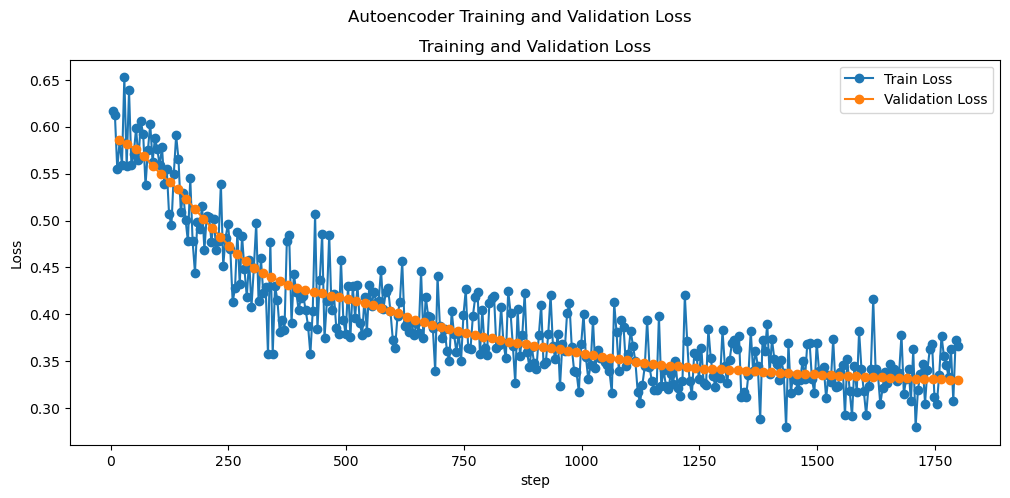

In [25]:
history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")